The point of this notebook is to demonstrate how to perform superpixel segmentation on a large ROI with nodata areas. There are some book-keeping issues related to this, but such small adherence to good labeling will really help us later.

In [2]:
import rasterio
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import felzenszwalb, relabel_sequential
from skimage.color import label2rgb
from tqdm import tqdm
from rscube import scale_img, polygonize_array_to_shapefile

# Opening the data

## ALOS Data

The ALOS data has been downloaded from the [ASF](https://search.asf.alaska.edu/#/?zoom=8.519989007460861&center=-91.630521,29.661597&polygon=POLYGON((-91.5491%2029.4,-91.2962%2029.4,-91.2962%2029.7394,-91.5491%2029.7394,-91.5491%2029.4))&dataset=ALOS&productTypes=RTC_HI_RES&polarizations=quadrature&resultsLoaded=true&granule=ALPSRP276440580-RTC_HI_RES) and denoised with [Mulog](https://www.charles-deledalle.fr/pages/files/mulog_high_quality_version.pdf).

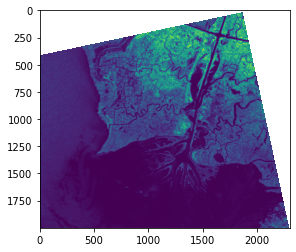

In [3]:
with rasterio.open('data/datacube_ROI/ALOS1_RTC_HH_201143_tv.tif') as ds:
    # clips between -30 and -3 db
    hh = np.clip(ds.read(1),
                 # Clipping range to -29 to 0 db
                 # lower bound
                 10**(-29 / 10.), 
                 # upperbound
                 10**(0 / 10.), 
                )
    profile = ds.profile
plt.imshow(hh)

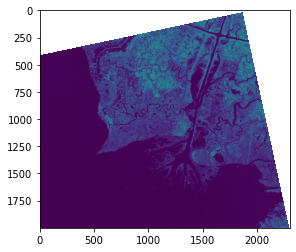

In [4]:
with rasterio.open('data/datacube_ROI/ALOS1_RTC_HV_201143_tv.tif') as ds:
    # clips between -30 and -3 db
    hv = np.clip(ds.read(1),
                 # Clipping range to -29 to -7 db
                 # lower bound
                 10**(-29 / 10.), 
                 # upperbound
                 10**(-7 / 10.), 
                )
    profile = ds.profile
plt.imshow(hv)

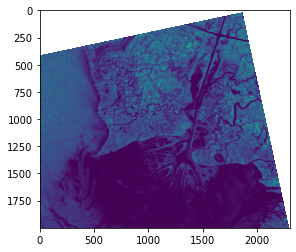

In [5]:
with rasterio.open('data/datacube_ROI/ALOS1_RTC_VV_201143_tv.tif') as ds:
    # clips between -30 and -3 db
    vv = np.clip(ds.read(1),
                 # Clipping range to -29 to 0 db
                 # lower bound
                 10**(-29 / 10.), 
                 # upperbound
                 10**(0 / 10.), 
                )
    profile = ds.profile
plt.imshow(vv)

## Hansen Data

In [6]:
DATA_DIR = Path('data/datacube_ROI/')
DATA_DIR.exists()

True

In [7]:
hansen_paths = sorted(list(DATA_DIR.glob('hansen*.tif')))
hansen_paths

[PosixPath('data/datacube_ROI/hansen_3.tif'),
 PosixPath('data/datacube_ROI/hansen_4.tif'),
 PosixPath('data/datacube_ROI/hansen_5.tif'),
 PosixPath('data/datacube_ROI/hansen_7.tif')]

In [8]:
def open_one(path):
    with rasterio.open(path) as ds:
        arr = ds.read(1)
    return arr

hansen_arrs = list(map(open_one, tqdm(hansen_paths)))

100%|██████████| 4/4 [00:00<00:00, 42.54it/s]


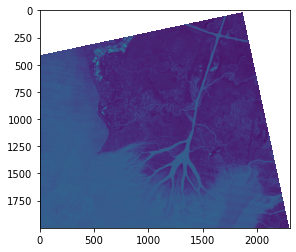

In [9]:
plt.imshow(hansen_arrs[0])

In [10]:
images = [hh,
          hv,
          vv]

images += hansen_arrs

## Reading the Mask

We assume that:
    
1. The masks are consistent through the time series
2. The mask can be read as `np.isnan(image)`, where `image` is one of the images in our datacube.

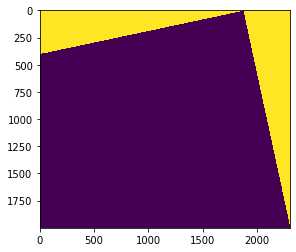

In [11]:
mask = np.isnan(images[0])
plt.imshow(mask, interpolation='none')

We'll save the mask for reference.

In [12]:
OUT_DIR = Path('out')
OUT_DIR.mkdir(exist_ok=True, parents=True)

In [13]:
p = profile.copy()
p['dtype'] = 'uint8'
p['nodata'] = None
with rasterio.open(OUT_DIR/'mask.tif', 'w', **p) as ds:
    ds.write(mask.astype(np.uint8), 1)

# Segmenting The Data

First, we want to scale each image so that its dynamic range is between 0 and 1. We scale according to the min and max within each image.

In [14]:
images_scaled = [scale_img(img) for img in images]

Because `skimage` doesn't deal with `np.nan` data, we assign mask values a value far outside the dynamic range to ensure they are grouped together.

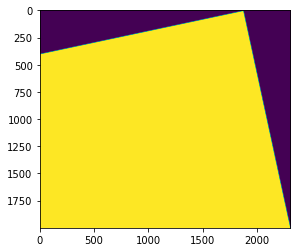

In [15]:
def mask_img(img):
    img_ = img.copy()
    img_[mask] = -9999
    return img_

images_scaled = list(map(mask_img, images_scaled))
plt.imshow(images_scaled[0])

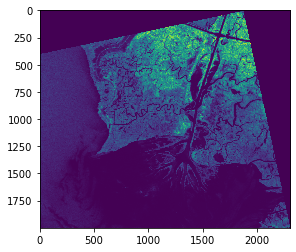

In [16]:
plt.imshow(images_scaled[0], vmin=0, interpolation='none')

Now, we stack our list of images into a multichannel image and then segment them according to the [Huttenlocher and Felzenszwalb](http://people.cs.uchicago.edu/~pff/papers/seg-ijcv.pdf) algorithm as implemented in [Scikit-image](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html#sphx-glr-auto-examples-segmentation-plot-segmentations-py).

In [17]:
images_stacked = np.stack(images_scaled, axis=2)
superpixel_labels = felzenszwalb(images_stacked,
                                 min_size=20,
                                 sigma=0,
                                 scale=.5)

/Users/cmarshak/anaconda3/envs/rscube/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: RuntimeWarning: Got image with third dimension of 7. This image will be interpreted as a multichannel 2d image, which may not be intended.
  exec(code_obj, self.user_global_ns, self.user_ns)


Now, we need to perform the little bit of bookkeeping we discussed at the beginning of the notebook. We want the following:

1. Masked areas to have label $0$
2. The other labels to have sequential labels $1, 2, 3, ..., n-1, n$

Although we made sure to make the masked areas far outside the dynamic range of the imagery ($[0, 1]$), the masked areas could have been merged with other labels. That's why it's important to do this bit of bookkeeping. The sequential labeling will be exploited as a lookup table within an area of statistics associated for each label.

In [18]:
# Make sure all labels are positive
superpixel_labels += 1
# Ensure that the mask areas all have 0 as a label
superpixel_labels[mask] = 0

# Make sure labels go from 1, 2, 3, 4, ... , n-1, n
# Per documentation only relabels postive labels (ignores mask)
superpixel_labels, _, _ = relabel_sequential(superpixel_labels, offset=1)

We also want to view our segments as a raster. We assign random colors to each label.

In [19]:
superpixel_labels_rgb = label2rgb(superpixel_labels, bg_label=0)

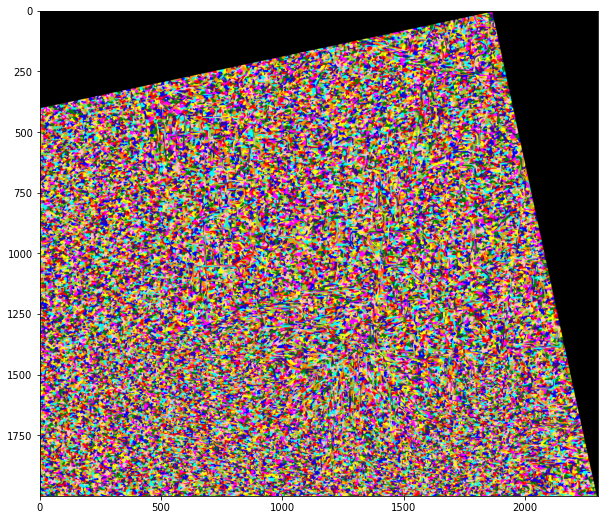

In [20]:
plt.figure(figsize=(10, 10))
plt.imshow(superpixel_labels_rgb)

# Saving the Segments

First as a GeoTiff:

In [21]:
p = profile.copy()
p['nodata'] = None
p['dtype'] = 'int32'
with rasterio.open(OUT_DIR/'superpixels.tif', 'w', **p) as ds:
    ds.write(superpixel_labels.astype(np.int32), 1)

p['count'] = 3
p['dtype'] = 'float64'
with rasterio.open(OUT_DIR/'superpixels_rgb.tif', 'w', **p) as ds:
    ds.write(superpixel_labels_rgb.transpose([2, 0, 1]))    

And then as a shapefile:

In [22]:
polygonize_array_to_shapefile(superpixel_labels, profile, OUT_DIR/'superpixels', mask=mask)